# CNN Model to predict seamounts 

In [1]:
import os
import cv2
from collections import Counter
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Parameters
image_folder = "./data_241208"  # Root directory of the dataset
output_folder = "temp_processed_data_241208"  # Temporary folder for cropped images
image_size = (128, 128)  # Image dimensions for the model
crop_pixels = 70  # Pixels to crop from each border

# Categories
categories = ["with_seamount_manual1", "without_seamounts_manual1"]  # Subfolders in `image_folder`

# Load processed dataset
def load_data(directory, categories):
    data, labels = [], []
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image)
                labels.append(label)
    return np.array(data), np.array(labels)

data, labels = load_data(output_folder, categories)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("Datasets loaded, normalized, and split")

def show_label_distribution(labels, dataset_name):
    label_counts = Counter(labels)
    print(f"Label distribution for {dataset_name} with {len(labels)} Images:")
    for label, count in label_counts.items():
        print(f"  Labels {label}: {count}")

# Show some basic stats about the datasets
show_label_distribution(y_train, "Training set")
show_label_distribution(y_val, "Validation set")
show_label_distribution(y_test, "Test set")

# Define the CNN model
model = Sequential([
    Input(shape=(image_size[0], image_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show architecture
print(model.summary())

# Learn parameters
batch_size = 16
epochs = 50

# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill mode for new pixels
)

# Fit the generator to the training data
train_datagen.fit(X_train)

# Train the model with augmented images
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Datasets loaded, normalized, and split
Label distribution for Training set with 700 Images:
  Labels 1: 350
  Labels 0: 350
Label distribution for Validation set with 150 Images:
  Labels 0: 72
  Labels 1: 78
Label distribution for Test set with 150 Images:
  Labels 1: 72
  Labels 0: 78
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                            

## Model evaluation details

In [2]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print(classification_report(y_test, y_pred, target_names=categories))

5/5 [==============================] - 0s 28ms/step - loss: 0.3291 - accuracy: 0.8733
Test Loss: 0.32906392216682434, Test Accuracy: 0.8733333349227905
5/5 [==============================] - 0s 4ms/step
                           precision    recall  f1-score   support

    with_seamount_manual1       0.82      0.96      0.89        78
without_seamounts_manual1       0.95      0.78      0.85        72

                 accuracy                           0.87       150
                macro avg       0.89      0.87      0.87       150
             weighted avg       0.88      0.87      0.87       150



## Save model
Optional save your model to compare and access models later
TODO: think about to better store different learning paramater

In [ ]:
# Save the model
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"seamount_classifier_model_v1_0-{current_datetime}.keras"

model.save(model_filename)
print(f"Model saved under {model_filename}")

## Re-Load a saved model

In [ ]:
# Load the model
model_filename = "seamount_classifier_model_v1_0-2024-12-16_20-32-12.keras"

model = load_model(model_filename)
print(f"Model under filename {model_filename} successfull loaded")

## Show diagram of learing process

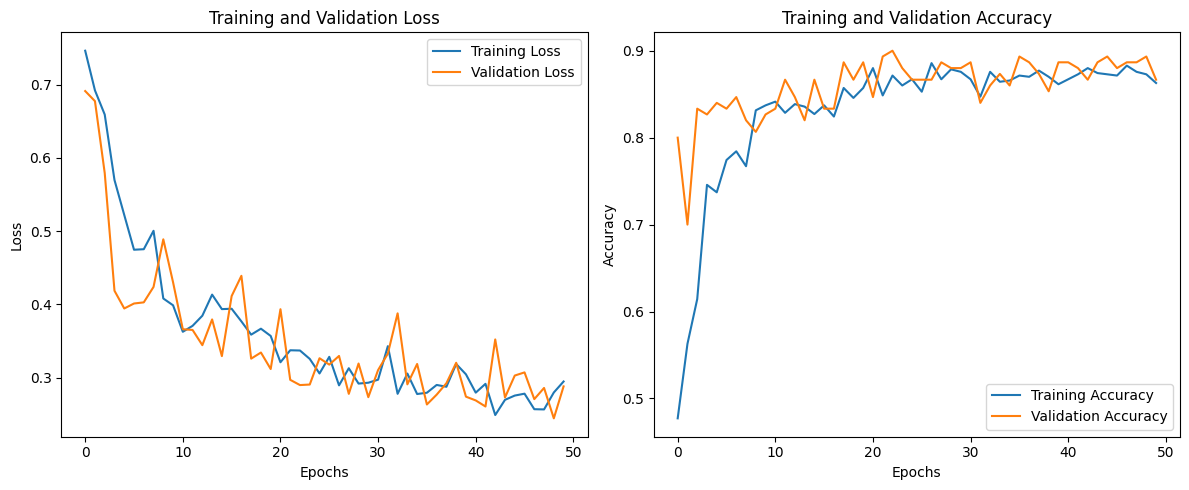

5/5 [==============================] - 0s 88ms/step


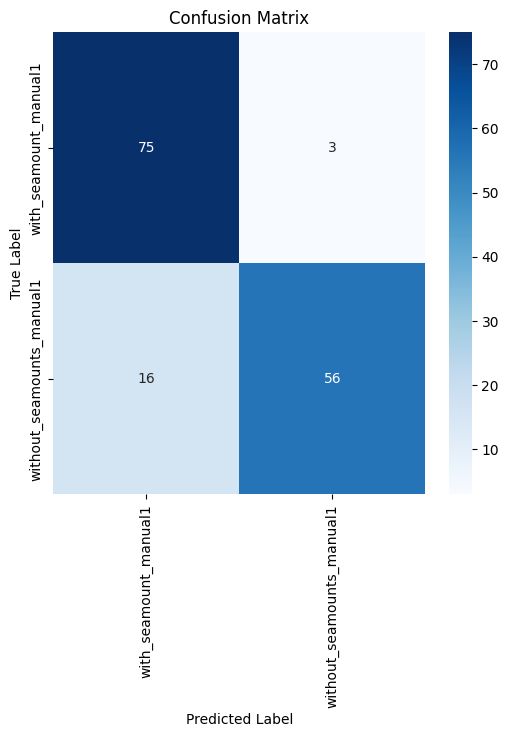

5/5 [==============================] - 0s 7ms/step


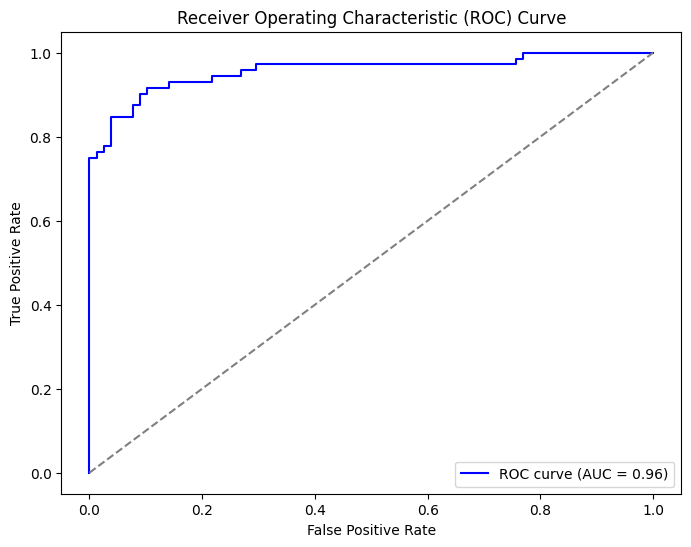

5/5 [==============================] - 0s 8ms/step
Classification Report:
                           precision    recall  f1-score   support

    with_seamount_manual1       0.82      0.96      0.89        78
without_seamounts_manual1       0.95      0.78      0.85        72

                 accuracy                           0.87       150
                macro avg       0.89      0.87      0.87       150
             weighted avg       0.88      0.87      0.87       150

Precision: 0.95
Recall: 0.78
F1 Score: 0.85


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Plotting the training/validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Compute confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test).flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## Show some details about the non-matches

In [ ]:
import matplotlib.pyplot as plt
import cv2
import math

# Get the indices of false positives and false negatives
false_positives = []
false_negatives = []

# Loop through the test set to find false positives and false negatives
for i in range(len(y_test)):
    if y_pred[i] == 1 and y_test[i] == 0:  # Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)
        false_positives.append(i)
    elif y_pred[i] == 0 and y_test[i] == 1:  # Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative)
        false_negatives.append(i)


# Display all False Positive images in a grid of 4 columns
num_images = len(false_positives)
columns = 4
rows = math.ceil(num_images / columns)

print(f"Found {num_images} False Positive images - Displaying all")

plt.figure(figsize=(columns * 3, rows * 3))  # Adjust figure size for better visualization

for i, index in enumerate(false_positives):
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)

    plt.subplot(rows, columns, i + 1)  # Add subplot at the corresponding position
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Remove axes for a cleaner look

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

# Display all False Negative images in a grid of 4 columns
num_images = len(false_negatives)
columns = 4
rows = math.ceil(num_images / columns)

print(f"Found {num_images} False Negative images - Displaying all")

plt.figure(figsize=(columns * 3, rows * 3))  # Adjust figure size for better visualization

for i, index in enumerate(false_negatives):
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)

    plt.subplot(rows, columns, i + 1)  # Add subplot at the corresponding position
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Remove axes for a cleaner look

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()